In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

In [2]:
# Local
import robustranking as rr

## Artificial data

In [3]:
competition = rr.Benchmark()
algorithms = [f"Algorithm-{i}" for i in range(1, 4)]
instances = [f"Instance-{i}" for i in range(1, 101)]
objectives = ["Runtime", "Quality"]

for a, i, o in itertools.product(algorithms, instances, objectives):
    factor = 0.5 if a == "Algorithm-1" else 1
    competition.add_run(a, i, o, factor * np.random.rand())
competition.add_run("Algorithm-1", "Instance-1", "Runtime", 1.0, replace=True)

competition.to_pandas()

value
algorithm   instance     objective          
Algorithm-1 Instance-1   Runtime    1.000000
                         Quality    0.249702
            Instance-2   Runtime    0.254999
                         Quality    0.137146
            Instance-3   Runtime    0.333630
...                                      ...
Algorithm-3 Instance-98  Quality    0.291699
            Instance-99  Runtime    0.854679
                         Quality    0.849149
            Instance-100 Runtime    0.141489
                         Quality    0.481641

[600 rows x 1 columns]

In [4]:
# competition.show_stats()

In [15]:
comparison = rr.comparison.BootstrapComparison(competition.filter(objectives="Runtime"),
                                 minimise=True,
                                 bootstrap_runs=1000,
                                 aggregation_method=np.mean)
comparison.get_ranking()
# comparison._get_distributions(always_minimise=True)

/Users/jeroen/Documents/Work/Projects/EmpiricalComparison/Experiments/robustranking/comparison/abstract_comparison.py:50: UserWarning: No results found. Start computations
  warnings.warn("No results found. Start computations")


,group,ranked 1st,group wins,remaining
algorithm,,,,
Algorithm-1,1,1.0,1.000,0.0
Algorithm-2,2,0.0,0.768,0.0
Algorithm-3,2,0.0,0.232,0.0


In [6]:
d = comparison._get_distributions()
d

array([[[0.25125998],
        [0.29030806],
        [0.25872632],
        ...,
        [0.24159747],
        [0.27108798],
        [0.24445908]],

       [[0.4752719 ],
        [0.48666603],
        [0.45387193],
        ...,
        [0.42435272],
        [0.45554444],
        [0.47482381]],

       [[0.4382561 ],
        [0.44874523],
        [0.42385239],
        ...,
        [0.43381967],
        [0.39217879],
        [0.48335635]]])

In [7]:
comparison = rr.comparison.MODominationBootstrapComparison(competition,
                                 minimise={"Runtime": True, "Quality": True},
                                 bootstrap_runs=100,
                                 aggregation_method=np.mean)
comparison.compute()

import logging
logging.basicConfig(level=logging.DEBUG)
comparison.get_ranking()

,group,ranked 1st,group wins,remaining
algorithm,,,,
Algorithm-1,1,1.0,2.00,0.0
Algorithm-2,2,0.0,0.84,0.0
Algorithm-3,2,0.0,1.16,0.0


In [8]:
d = comparison._get_distributions()
pd.DataFrame(d.reshape(3,-1)).T.describe()

,0,1,2
count,100.0,100.000000,100.000000
mean,0.0,1.580000,1.420000
std,0.0,0.290593,0.290593
min,0.0,1.000000,1.000000
25%,0.0,1.500000,1.000000
50%,0.0,1.500000,1.500000
75%,0.0,2.000000,1.500000
max,0.0,2.000000,2.000000


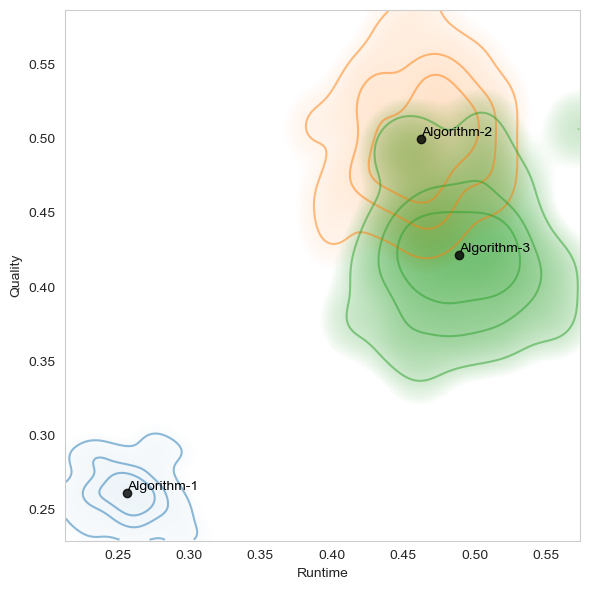

In [9]:
rr.utils.plots.plot_ci_density_estimations(comparison, competition.algorithms, show_names=True)

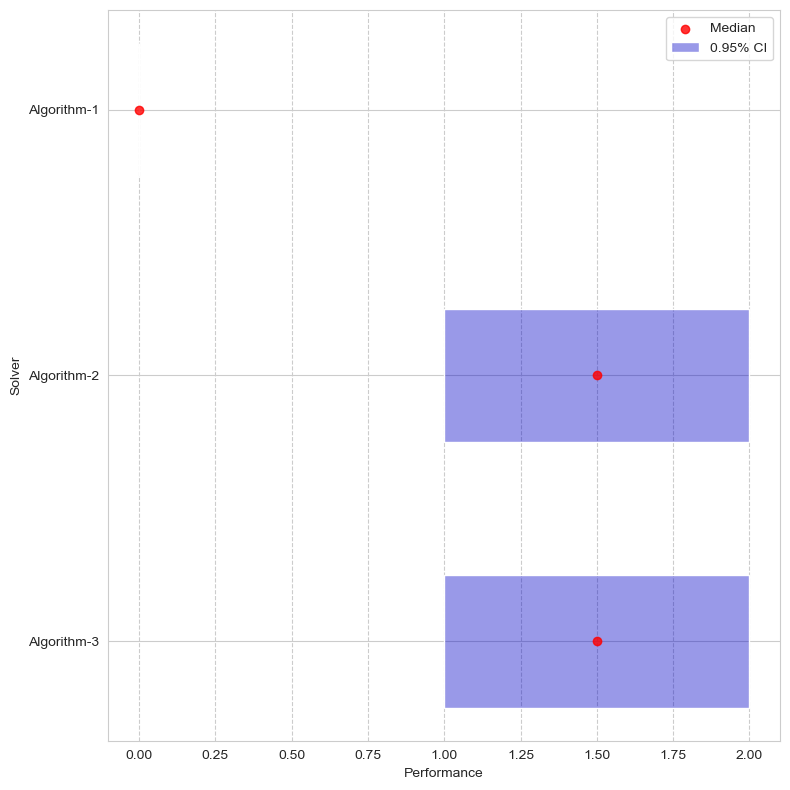

In [10]:
rr.utils.plots.plot_ci_list(comparison, objective="ranking_score")

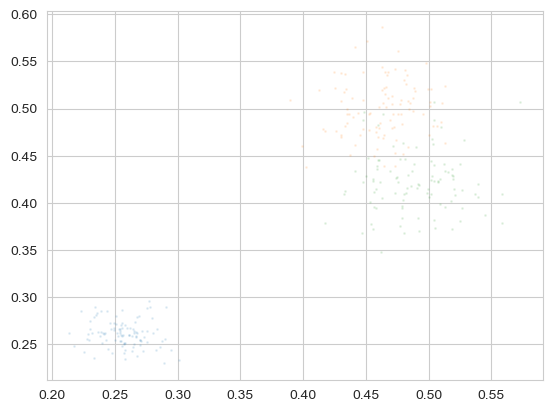

In [11]:
performances = comparison._cache["distributions"]

for alg in range(performances.shape[0]):
    x = performances[alg,:,0]
    y = performances[alg,:,1]

    plt.scatter(x, y, s=1, alpha=0.1)
plt.show()


AttributeError: 'PathCollection' object has no property 'm'

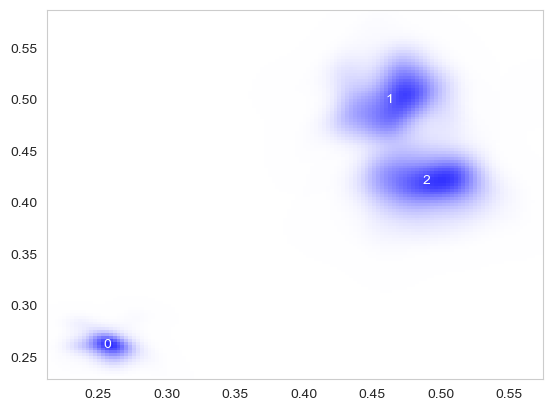

In [12]:
performances = comparison._cache["distributions"]
from scipy.stats import gaussian_kde
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
cmap1 = matplotlib.colors.ListedColormap(['none', 'green'])
colors = [
    (1, 1, 1, 0),
    (0.2, 0.2, 1, 1)
]
cmap1 = LinearSegmentedColormap.from_list("alpha", colors, N=256)

for alg in range(performances.shape[0]):
    x = performances[alg,:,0]
    y = performances[alg,:,1]
    k = gaussian_kde([x, y])
    resolution = 128
    xi, yi = np.mgrid[
             performances[:,:,0].min():performances[:,:,0].max():resolution*1j,
             performances[:,:,1].min():performances[:,:,1].max():resolution*1j
             ]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading="auto", cmap=cmap1, zorder=1)
    plt.text(np.mean(x), np.mean(y), f"{alg}", zorder=30, ha="center", va="center", c="white")

plt.scatter(*zip(*(np.mean(performances, axis=1).tolist())), c="red", m="+")
plt.grid()

plt.show()

In [ ]:
performances = comparison._cache["distributions"]
columns=["algo", "bootstrap", "objective"]
index = pd.MultiIndex.from_product([range(s) for s in performances.shape], names=columns)
df = pd.DataFrame({'performances': performances.flatten()}, index=index)['performances']
df = df.unstack("objective").reset_index()
df = df[df["algo"].isin(np.random.choice(df["algo"].unique(), 5, replace=False))]
df["algo"] = [comparison._cache["meta_data"]["algorithms"][a] for a in df["algo"]]

sns.jointplot(df, x=0, y=1, hue="algo", kind="kde")

In [ ]:
a = [False, True, True, False, True]

np.argwhere(a)[np.argmax(0)]

In [ ]:
comparison.get_confidence_intervals()

In [ ]:
comparison.get_ranking()

## SAT 2022 main track

In [ ]:
df = pd.read_csv("../examples/Rundata/sc2022-detailed-results/main-seq.csv")
del df["verified-result"]
del df["claimed-result"]
del df["hash"]
df = df.set_index(["benchmark"])
df = df.stack().reset_index().rename(columns={"level_1": "algorithm", "benchmark": "instance", 0: "PAR2"})
df["Solved"] = df["PAR2"] < 10000  # Solved instances
#df = df.set_index(["algorithm", "instance"])#.stack().reset_index().rename(columns={"level_2": "objective", 0: "value"})

competition = Benchmark()
competition.from_pandas(df, "algorithm", "instance", ["PAR2", "Solved"])
print("Complete table:", competition.check_complete())
competition.to_pandas().unstack("objective")

In [ ]:
comparison = MOBootstrapComparison(competition,
                                 alpha=0.05,
                                 minimise={"PAR2": True, "Solved": False},
                                 bootstrap_runs=10000,
                                 aggregation_method={"PAR2": np.mean, "Solved": np.sum})
%time comparison.compute()

In [ ]:
comparison.get_ranking()

In [ ]:
from robustranking.utils.plots import *
algorithms = ["Kissat_MAB-HyWalk", "SeqFROST-NoExtend"]
plot_distributions_comparison(comparison, algorithms)

In [ ]:
comparison.statistical_test(*algorithms)

In [ ]:
cache = comparison._get_cache()
s1 = cache["meta_data"]["algorithms"].index(algorithms[0])
s2 = cache["meta_data"]["algorithms"].index(algorithms[1])

distributions = cache["distributions"]
p_value = comparison.statistical_test(*algorithms)
direction = -1 if comparison.minimise else 1
diff = direction * (distributions[s1,:] - distributions[s2,:])
diff = np.sort(diff)
plt.grid()
plt.plot(np.linspace(0, 1, len(diff)),diff)
plt.axhline(0, c="black", linewidth=1.25, linestyle="-")
plt.axvline(p_value, c="red", linestyle="--")
plt.ylabel("Performance difference")
plt.show()


In [ ]:
comparison = SubSetComparison(competition,
                              alpha=0.05,
                              minimise=True,
                              subset_size=2,
                              aggregation_method=PAR(2, 5000))
%time comparison.compute()

In [ ]:
competition.objectives

comp1 = BootstrapComparison(competition.filter(objectives="PAR2"),
                            alpha=0.05,
                            minimise=True,
                            bootstrap_runs=10000,
                            aggregation_method=np.mean)

comp2 = BootstrapComparison(com)